In [1]:
#imports for VAE module
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn

#imports for training
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

#imports for dataset
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

#imports for loss function
from IPython.display import HTML, display

## VAE Module 
- Input img (x)
- Hidden dim
- mean, std
- paremterization trick
- Decoder 
- Ouput img 

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module): 
    def __init__(self, input_dim=784, hidden_dim=400, latent_z_dim=20): 
        super(VAE, self).__init__()
        # Encoder
        self.img_to_hidden = nn.Linear(input_dim, hidden_dim)
        self.hidden_to_mean = nn.Linear(hidden_dim, latent_z_dim)
        self.hidden_to_logvar = nn.Linear(hidden_dim, latent_z_dim)
        # Decoder
        self.latent_to_hidden = nn.Linear(latent_z_dim, hidden_dim)
        self.hidden_to_img = nn.Linear(hidden_dim, input_dim)

    def encode(self, x): 
        h = F.relu(self.img_to_hidden(x))
        mu = self.hidden_to_mean(h)
        logvar = self.hidden_to_logvar(h)
        return mu, logvar

    def decode(self, z): 
        h = F.relu(self.latent_to_hidden(z))
        x_hat = self.hidden_to_img(h)
        return torch.sigmoid(x_hat)

    def reparameterize(self, mu, logvar): 
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mu + std * epsilon

    def forward(self, x): 
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar, z

    def loss_function(self, x, x_hat, mu, logvar): 
        recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss, kl_loss, recon_loss + kl_loss


## Training Module

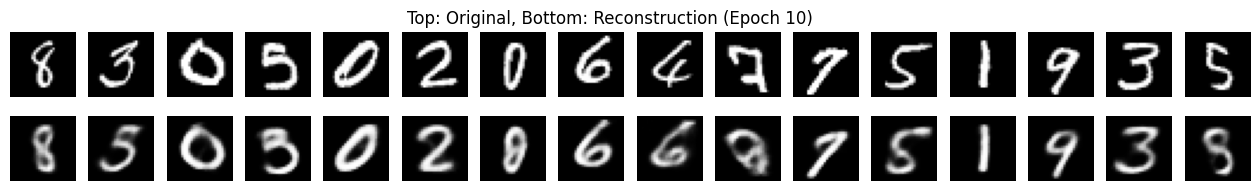

Epoch: 10, Batch Size: 100, Learning Rate: 0.001, Hidden Dim: 400, Latent Z Dim: 8, Loss: 122674.84430989584
Best model: VAE(
  (img_to_hidden): Linear(in_features=784, out_features=400, bias=True)
  (hidden_to_mean): Linear(in_features=400, out_features=8, bias=True)
  (hidden_to_logvar): Linear(in_features=400, out_features=8, bias=True)
  (latent_to_hidden): Linear(in_features=8, out_features=400, bias=True)
  (hidden_to_img): Linear(in_features=400, out_features=784, bias=True)
)
Best loss: 122674.84430989584


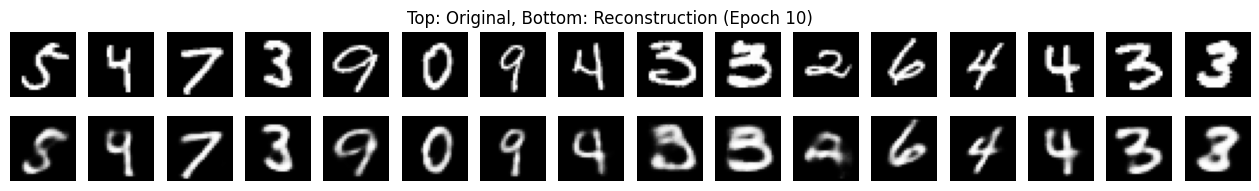

Epoch: 10, Batch Size: 100, Learning Rate: 0.001, Hidden Dim: 400, Latent Z Dim: 16, Loss: 114767.53454915364
Best model: VAE(
  (img_to_hidden): Linear(in_features=784, out_features=400, bias=True)
  (hidden_to_mean): Linear(in_features=400, out_features=16, bias=True)
  (hidden_to_logvar): Linear(in_features=400, out_features=16, bias=True)
  (latent_to_hidden): Linear(in_features=16, out_features=400, bias=True)
  (hidden_to_img): Linear(in_features=400, out_features=784, bias=True)
)
Best loss: 114767.53454915364


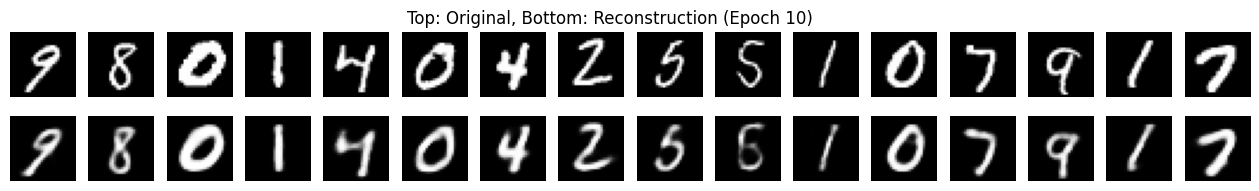

Epoch: 10, Batch Size: 100, Learning Rate: 0.001, Hidden Dim: 400, Latent Z Dim: 32, Loss: 115181.81890950521
Best model: VAE(
  (img_to_hidden): Linear(in_features=784, out_features=400, bias=True)
  (hidden_to_mean): Linear(in_features=400, out_features=16, bias=True)
  (hidden_to_logvar): Linear(in_features=400, out_features=16, bias=True)
  (latent_to_hidden): Linear(in_features=16, out_features=400, bias=True)
  (hidden_to_img): Linear(in_features=400, out_features=784, bias=True)
)
Best loss: 114767.53454915364


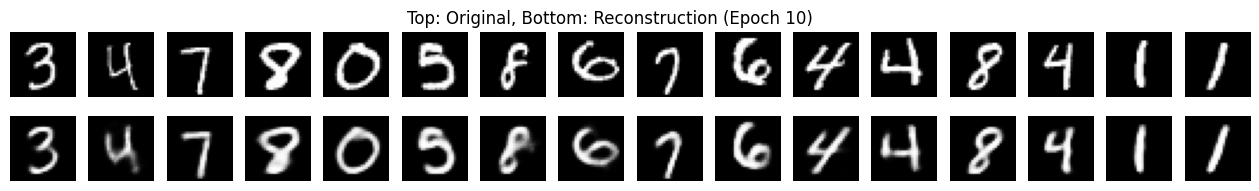

Epoch: 10, Batch Size: 100, Learning Rate: 0.001, Hidden Dim: 400, Latent Z Dim: 64, Loss: 116230.91564127603
Best model: VAE(
  (img_to_hidden): Linear(in_features=784, out_features=400, bias=True)
  (hidden_to_mean): Linear(in_features=400, out_features=16, bias=True)
  (hidden_to_logvar): Linear(in_features=400, out_features=16, bias=True)
  (latent_to_hidden): Linear(in_features=16, out_features=400, bias=True)
  (hidden_to_img): Linear(in_features=400, out_features=784, bias=True)
)
Best loss: 114767.53454915364


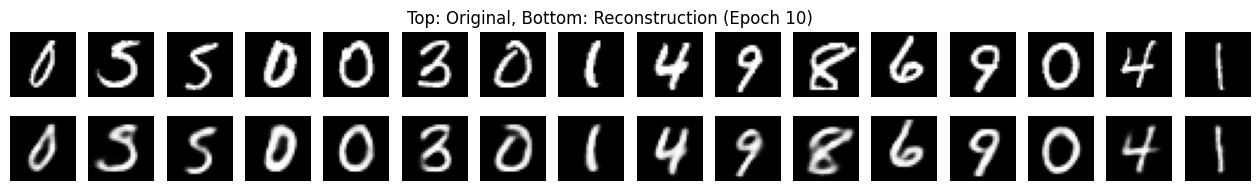

Epoch: 10, Batch Size: 100, Learning Rate: 0.001, Hidden Dim: 400, Latent Z Dim: 128, Loss: 117688.41227864583
Best model: VAE(
  (img_to_hidden): Linear(in_features=784, out_features=400, bias=True)
  (hidden_to_mean): Linear(in_features=400, out_features=16, bias=True)
  (hidden_to_logvar): Linear(in_features=400, out_features=16, bias=True)
  (latent_to_hidden): Linear(in_features=16, out_features=400, bias=True)
  (hidden_to_img): Linear(in_features=400, out_features=784, bias=True)
)
Best loss: 114767.53454915364


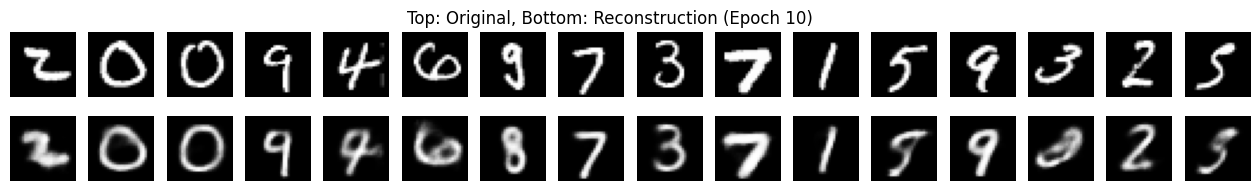

Epoch: 10, Batch Size: 100, Learning Rate: 0.001, Hidden Dim: 500, Latent Z Dim: 8, Loss: 121065.54946777344
Best model: VAE(
  (img_to_hidden): Linear(in_features=784, out_features=400, bias=True)
  (hidden_to_mean): Linear(in_features=400, out_features=16, bias=True)
  (hidden_to_logvar): Linear(in_features=400, out_features=16, bias=True)
  (latent_to_hidden): Linear(in_features=16, out_features=400, bias=True)
  (hidden_to_img): Linear(in_features=400, out_features=784, bias=True)
)
Best loss: 114767.53454915364


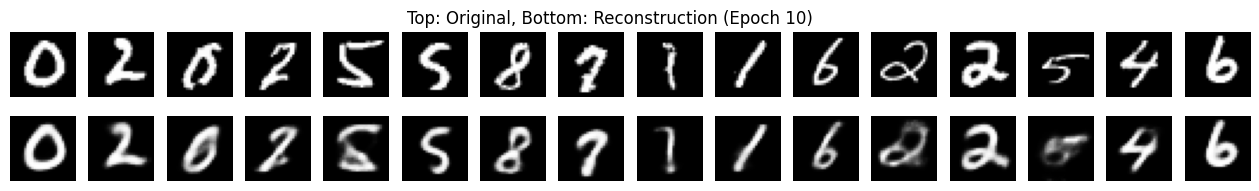

Epoch: 10, Batch Size: 100, Learning Rate: 0.001, Hidden Dim: 500, Latent Z Dim: 16, Loss: 113632.85895507812
Best model: VAE(
  (img_to_hidden): Linear(in_features=784, out_features=500, bias=True)
  (hidden_to_mean): Linear(in_features=500, out_features=16, bias=True)
  (hidden_to_logvar): Linear(in_features=500, out_features=16, bias=True)
  (latent_to_hidden): Linear(in_features=16, out_features=500, bias=True)
  (hidden_to_img): Linear(in_features=500, out_features=784, bias=True)
)
Best loss: 113632.85895507812


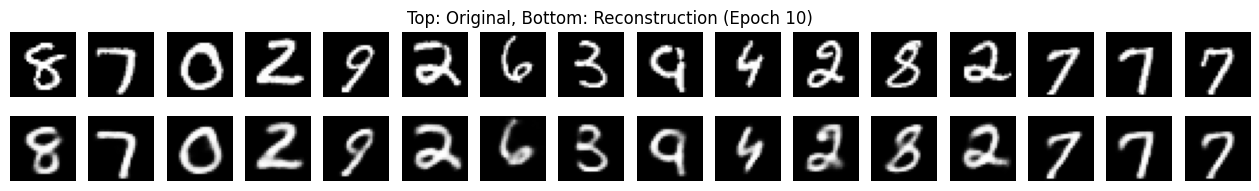

Epoch: 10, Batch Size: 100, Learning Rate: 0.001, Hidden Dim: 500, Latent Z Dim: 32, Loss: 113849.49913736978
Best model: VAE(
  (img_to_hidden): Linear(in_features=784, out_features=500, bias=True)
  (hidden_to_mean): Linear(in_features=500, out_features=16, bias=True)
  (hidden_to_logvar): Linear(in_features=500, out_features=16, bias=True)
  (latent_to_hidden): Linear(in_features=16, out_features=500, bias=True)
  (hidden_to_img): Linear(in_features=500, out_features=784, bias=True)
)
Best loss: 113632.85895507812


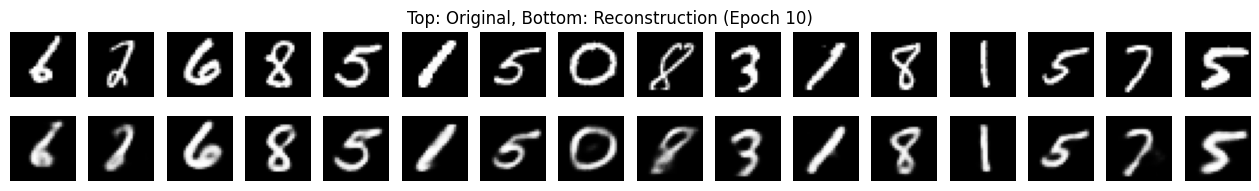

Epoch: 10, Batch Size: 100, Learning Rate: 0.001, Hidden Dim: 500, Latent Z Dim: 64, Loss: 115041.36332845052
Best model: VAE(
  (img_to_hidden): Linear(in_features=784, out_features=500, bias=True)
  (hidden_to_mean): Linear(in_features=500, out_features=16, bias=True)
  (hidden_to_logvar): Linear(in_features=500, out_features=16, bias=True)
  (latent_to_hidden): Linear(in_features=16, out_features=500, bias=True)
  (hidden_to_img): Linear(in_features=500, out_features=784, bias=True)
)
Best loss: 113632.85895507812


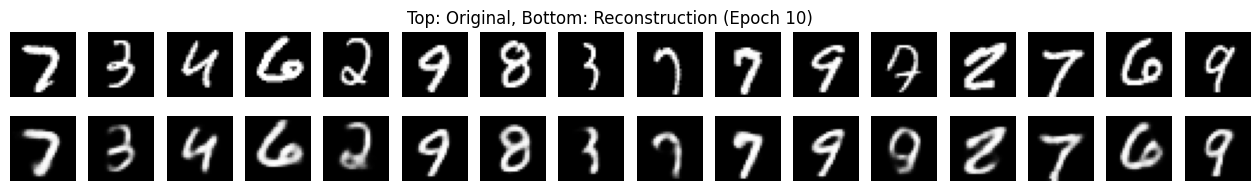

Epoch: 10, Batch Size: 100, Learning Rate: 0.001, Hidden Dim: 500, Latent Z Dim: 128, Loss: 116544.55087565104
Best model: VAE(
  (img_to_hidden): Linear(in_features=784, out_features=500, bias=True)
  (hidden_to_mean): Linear(in_features=500, out_features=16, bias=True)
  (hidden_to_logvar): Linear(in_features=500, out_features=16, bias=True)
  (latent_to_hidden): Linear(in_features=16, out_features=500, bias=True)
  (hidden_to_img): Linear(in_features=500, out_features=784, bias=True)
)
Best loss: 113632.85895507812


In [ ]:
class Trainer():
    
    def __init__(self, model, device, epochs=10, batch_size=100, learning_rate=0.001, input_dim=784, dataloader=None):
        
        #hyperparameters
        self.model = model
        self.device = device
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.input_dim = input_dim
        self.dataloader = dataloader
        
        #optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
    def train(self, fixed_x): 
        
        avg_loss = 0
        
        #training loop
        for epoch in range(self.epochs): 
            for i, (x, _) in enumerate(self.dataloader): 
                
                #move to device
                x = x.reshape(-1, self.input_dim).to(self.device)
                
                #reconstruction 
                x_hat, mu, logvar, z = self.model(x)
                
                #loss function
                recon_loss, kl_loss, loss = self.model.loss_function(x, x_hat, mu, logvar)
                
                #backpropagation
                self.optimizer.zero_grad()  #zero the gradients
                loss.backward()  #backpropagation
                self.optimizer.step()  #update the parameters 
                
                #average loss
                avg_loss += loss.item()
                
                #print loss
                if i % 20 == 0: 
                        print(f"Epoch [{epoch+1}/{self.epochs}] | Batch [{i+1}/{len(self.dataloader)}] | Loss {loss.item():.4f} | Reconstruction Loss {recon_loss.item():.4f} | KL Divergence Loss {kl_loss.item():.4f}", end="\r", flush=True)
            
        #visulize after training
        with torch.no_grad():
            recon, _, _, _ = model(fixed_x)
            recon = recon.view(-1, 1, 28, 28).cpu()
            fig, axes = plt.subplots(2, 16, figsize=(16, 2))
            for j in range(16):
                axes[0, j].imshow(fixed_x[j].cpu().view(28, 28), cmap='gray')
                axes[0, j].axis('off')
                axes[1, j].imshow(recon[j].view(28, 28), cmap='gray')
                axes[1, j].axis('off')
            plt.suptitle(f"Top: Original, Bottom: Reconstruction (Epoch {epoch+1})")
            print(f"Epoch [{epoch+1}/{self.epochs}] | Batch [{i+1}/{len(self.dataloader)}] | Loss {loss.item():.4f} | Reconstruction Loss {recon_loss.item():.4f} | KL Divergence Loss {kl_loss.item():.4f}", end="\r", flush=True)
            plt.show()
                
        #average loss
        avg_loss /= len(self.dataloader)
                
        #return the trained model
        return self.model, avg_loss


if __name__ == "__main__": 
    
    #hyperparameters
    epochs = [10, 20, 30, 40, 50]
    batch_sizes = [100, 200, 300, 400, 500]
    learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
    hidden_dims = [400, 500, 600, 700, 800]
    latent_z_dims = [8, 16, 32, 64, 128]
    input_dim = 784
    
    #best model saving
    best_model = None
    best_loss = float('inf')
    
    for epoch in epochs:
        for batch_size in batch_sizes:
            for learning_rate in learning_rates:
                for hidden_dim in hidden_dims:
                    for latent_z_dim in latent_z_dims:
                        
                        #importing MNIST dataset
                        dataset = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
                        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
                        
                        #device
                        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                        
                        #model & trainer module initialization
                        model = VAE(input_dim, hidden_dim, latent_z_dim).to(device)
                        trainer = Trainer(model, device, epoch, batch_size, learning_rate, input_dim, dataloader)
                        
                        #fixed batch of images
                        fixed_x, fixed_y = next(iter(dataloader))
                        fixed_x = fixed_x[:16].reshape(-1, input_dim).to(device)
                        
                        #train the model
                        model, loss = trainer.train(fixed_x)
                        
                        #save the model if it has the best loss
                        if loss < best_loss:
                            best_loss = loss
                            best_model = model
                            
                        #model stats
                        print(f"Epoch: {epoch}, Batch Size: {batch_size}, Learning Rate: {learning_rate}, Hidden Dim: {hidden_dim}, Latent Z Dim: {latent_z_dim}, Loss: {loss}")
                        print(f"Best model: {best_model}")
                        print(f"Best loss: {best_loss}")

    
    #save the best model
    torch.save(best_model.state_dict(), f"best_model_{epoch}_{batch_size}_{learning_rate}_{hidden_dim}_{latent_z_dim}.pth")
                        